Figure 3: Shock predicting cell co-firing stifled by ANI administration

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Set up Figure 3 and S6 (example freeze-tuned rasters) and maybe S7 (ensemble analysis)

Plot #1: Example motion trace with cell activity overlaid.  Ideally this would show two neurons that aren't tuned together before shock and then activate together after shock.

Plot #2: Example freeze-tuned cell rasters from each group?

[8.5 6.5]
[8.5 6.5]


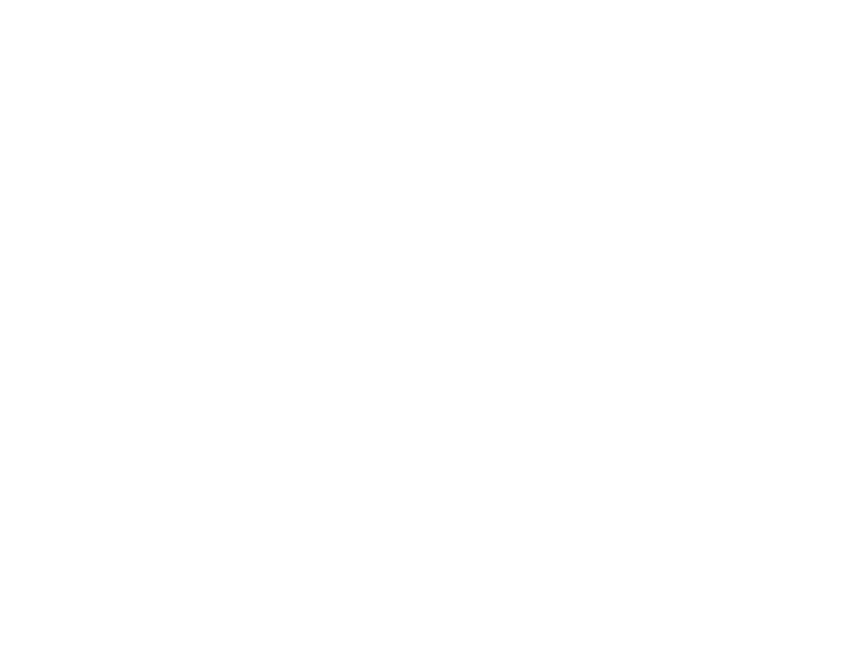

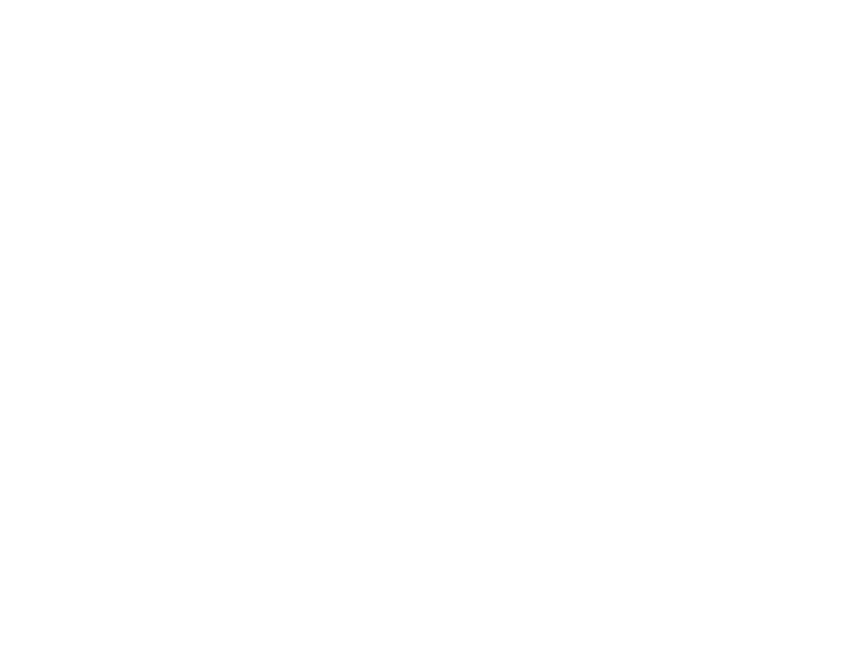

In [2]:
%matplotlib ipympl
Fig3 = Fig(num=3, grid=(4, 4), size=(8.5, 6.5), fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(Fig3.fig.get_size_inches())
Fig3stats = Fig(num="Figure 3 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6) 
print(Fig3stats.fig.get_size_inches())
Fig3comb = FigMirror(Fig3, Fig3stats)

[8.5 6.5]
[8.5 6.5]


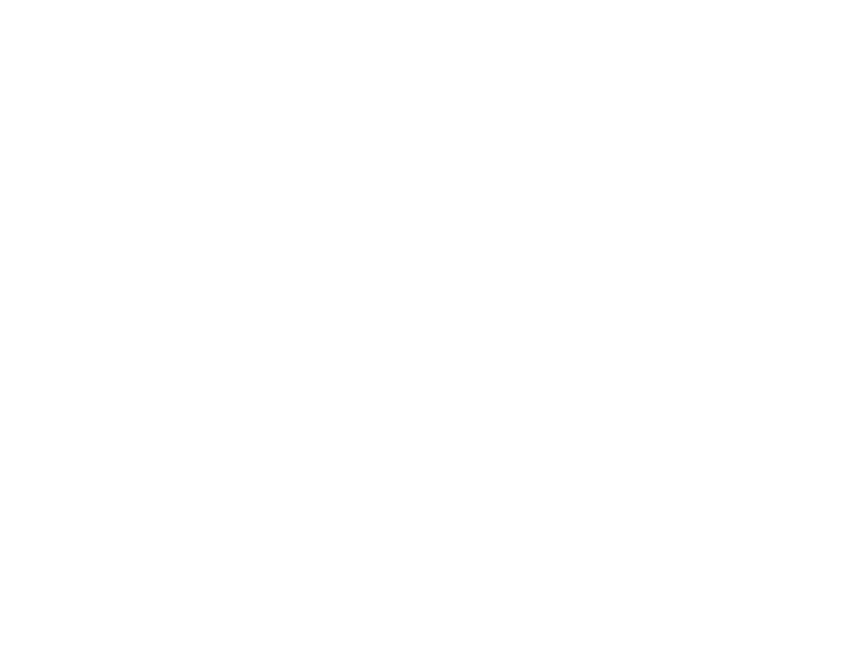

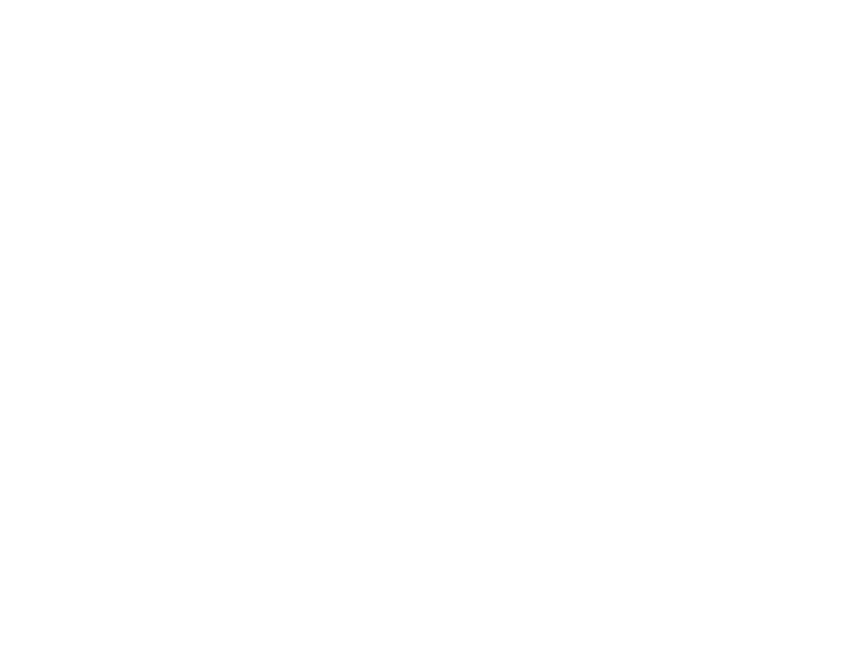

In [3]:
%matplotlib ipympl
FigS6 = Fig(num="S6", grid=(4, 4), size=(8.5, 6.5), fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(FigS6.fig.get_size_inches())
FigS6stats = Fig(num="Figure S6 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6) 
print(FigS6stats.fig.get_size_inches())
FigS6comb = FigMirror(FigS6, FigS6stats)

First, plot example freezing cells from Marble07: 53, 67, 90, and 334

In [4]:
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2])

<AxesSubplot:>

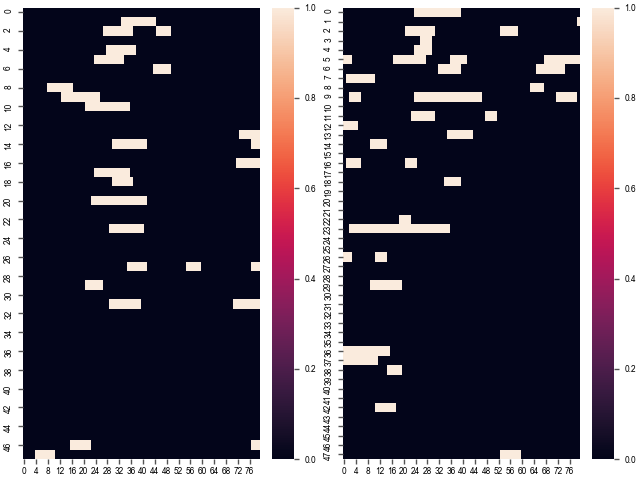

In [5]:
# Example raster side-by-side for sanity check on high covariance of these two cells
_, ax = plt.subplots(1, 2)
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][334], ax=ax[0])
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][53], ax=ax[1])

### Plot example traces from freeze-tuned cells. Blue = 53, Pink = 334.

In [6]:
# Plot example traces from freeze-tuned cells. Blue = 53, Pink = 334.
ax_ex_cell_cofire = Fig3.subplot2grid(Fig3.gs[0, 0:3], grid=(1, 2), return_axes=True)
neurons_plot = [53, 334]
im_data = sio.loadmat(mmd.motion_tuning['Shock'][1].dir_use / 'FinalOutput.mat')
rawtraces = im_data['NeuronTraces']['RawTrace'].squeeze().item()
rawtraces = rawtraces[:, :mmd.motion_tuning['Shock'][1].PSAbool.shape[1]]  # Align rawtraces with PSAbool
rawz = (rawtraces - rawtraces.mean(axis=1)[:, None])/rawtraces.std(axis=1)[:, None]
psabool = mmd.motion_tuning['Shock'][1].PSAbool
t = np.arange(0, mmd.motion_tuning['Shock'][1].PSAbool.shape[1])/mmd.motion_tuning['Shock'][1].sr_image
for ax, xlim in zip(ax_ex_cell_cofire, ([265, 290], [340, 380])):
    for psa, trace in zip(psabool[[neurons_plot]].astype(bool), rawz[[neurons_plot]]):
        ax.plot(t, trace)
        for event_idx in contiguous_regions(psa):
            ax.plot(t[event_idx[0]:event_idx[1]], trace[event_idx[0]:event_idx[1]], 'r')

    for ftimes in mmd.motion_tuning['Shock'][1].freezing_times:
        ax.axvspan(ftimes[0], ftimes[1], color=[0, 1, 0, 0.3])

    ax.set_xlim(xlim)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_7987/3526632726.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for psa, trace in zip(psabool[[neurons_plot]].astype(bool), rawz[[neurons_plot]]):
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_7987/3526632726.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for psa, trace in zip(psabool[[neurons_plot]].astype(bool), rawz[[neurons_plot]]):


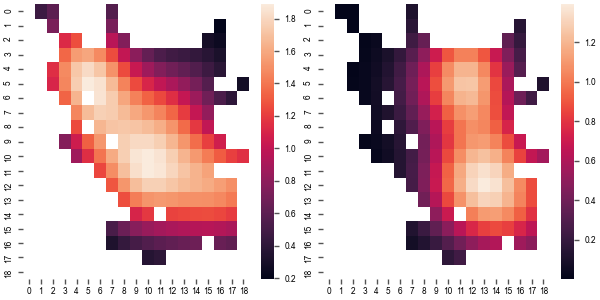

In [7]:
# Plot heatmaps as sanity check - these aren't just overlapping place cells. 
# Rather, they fire in a lot of different places
PF = pf.load_pf('Marble07', 'Shock', 1)
_, ax = plt.subplots(1, 2, figsize=(6, 3))
for a, nid in zip(ax, neurons_plot):
    sns.heatmap(PF.tmap_sm[nid], ax=a)

In [8]:
# Other example cell for supplemental - Non-Learner
axnonlrncell, axnonlrncell_stats = FigS6comb.subplot2grid(FigS6.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble11', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(584, base_day=1, base_arena='Shock', batch_map=False, 
                            plot_ROI=False, ax=axnonlrncell, rasterized=True)

Assembling neuron map for base_day=1 and base_arena=Shock
Cannot find normal map - trying to run in reverse
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 813'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 7'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 584'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 324'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [9]:
# Other example cell for supplemental - Learner
axlrncell3, axlrncell3_stats = FigS6comb.subplot2grid(FigS6.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble24', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(36, base_day=1, base_arena='Shock', batch_map=False, 
                            plot_ROI=False, ax=axlrncell3, rasterized=True)

Assembling neuron map for base_day=1 and base_arena=Shock
Cannot find normal map - trying to run in reverse
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())


array([<AxesSubplot:>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 60'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 36'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 259'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [10]:
# Maybe better learner cell?
axlrncella, axlrncella_stats = Fig3comb.subplot2grid(Fig3.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(334, base_day=1, base_arena='Shock', batch_map=False, 
                            plot_ROI=False, ax=axlrncella.squeeze(), label_fig=False, rasterized=True)

Assembling neuron map for base_day=1 and base_arena=Shock
Cannot find normal map - trying to run in reverse
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 508'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 341'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 334'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 16'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [11]:
# Example learner cell
axlrncellb, axlrncellb_stats = Fig3comb.subplot2grid(Fig3.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(53, base_day=1, base_arena='Shock', batch_map=False,
                           plot_ROI=False, ax=axlrncellb.squeeze(), label_fig=False, rasterized=True) 

Assembling neuron map for base_day=1 and base_arena=Shock
Cannot find normal map - trying to run in reverse
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 547'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 7'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 53'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 14'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [12]:
# Example unstable ANI cell
# Need to update this to look out +/- 2 sec due to different frame rate
axanicell, axanicell_stats = Fig3comb.subplot2grid(Fig3.gs[3, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble20', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(2, base_day=4, base_arena='Shock', batch_map=False,
                           plot_ROI=False, ax=axanicell.squeeze(), label_fig=False, rasterized=True)

Assembling neuron map for base_day=4 and base_arena=Shock
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 125'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 2'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 18'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 217'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [13]:
axlrncell2, axlrncell2_stats = FigS6comb.subplot2grid(FigS6.gs[3, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble27', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(22, base_day=4, base_arena='Shock', batch_map=False,
                           plot_ROI=False, ax=axlrncell2.squeeze(), label_fig=False, rasterized=True)

Assembling neuron map for base_day=4 and base_arena=Shock
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 39'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 22'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 170'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 178'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

Plot #2b: Proportion freeze-tuned across days

In [14]:
# First create dataframe with proportion tuned values
mice_groups = [err.learners, err.nonlearners, err.ani_mice_good]
day_list, arena_list, group_list, exp_group_list, prop_tuned_list, mouse_list = [], [], [], [], [], []
group_names = ['Learners', 'Nonlearners', 'ANI']
exp_group_names = ['Control', 'Control', 'ANI']
days = [-1, 4, 1, 2]
for arena in ['Open', 'Shock']:
    for group, exp_group_name, group_name in zip(mice_groups, exp_group_names, group_names):
        for mouse in group:
            mmd = fa.MotionTuningMultiDay(mouse, arena=arena, days=days)
            p_tuned = mmd.get_prop_tuned()
            group_list.extend([group_name]*len(p_tuned))
            exp_group_list.extend([exp_group_name]*len(p_tuned))
            day_list.extend(days)
            arena_list.extend([arena]*len(p_tuned))
            prop_tuned_list.extend(p_tuned)
            mouse_list.extend([mouse]*len(p_tuned))


df_prop = pd.DataFrame({'Exp Group': exp_group_list, 'Group': group_list, 'Mouse': mouse_list,
                            'Day': day_list, 'Arena': arena_list, 'Prop Tuned': prop_tuned_list})

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38


### Proportion of cells that are freeze-tuned in shock arena - open goes into supplemental

In [15]:
axprop, axprop_stats = Fig3comb.subplot(444)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axprop, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axprop, order=days)
axprop.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows


In [16]:
axpropo, axpropo_stats = FigS6comb.subplot(444)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axpropo, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axpropo, order=days)
axpropo.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows

### Freeze-tuned cell firing stability across days is higher in learners than non-learners from 4 to 1-hour session

In [17]:
ax_frz_stab1, ax_frz_stab1_stats = Fig3comb.subplot(447)
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 1
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta, 
                                           ax=[ax_frz_stab1, ax_frz_stab1_stats], size=2, alpha=0.7, jitter=0.15)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [18]:
ax_frz_stab4, ax_frz_stab4_stats = Fig3comb.subplot(448)
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 4
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta,
                                           ax=[ax_frz_stab4, ax_frz_stab4_stats], size=2, alpha=0.7, jitter=0.15)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Plot #3a (Supplemental): Ensemble plots - show example of a couple ensembles that form and how they match freeze-cells.

### Plots of ANI effects on shock cell covariance and all cell covariance


In [19]:
from copy import deepcopy

def add_memory_designations(df_use, before=['-2_-1', '-1_4'], during=['4_1'], after=['1_2', '2_7']):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["d1_d2"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["d1_d2"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["d1_d2"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

In [20]:
## NRK note - this was a rough go and getting stats quickly in the beginning but has been replaced by a more rigorou
# ANOVA with post-hoc tests
import scipy.stats as stats
def stats_before_after(df_use, key_use, ax=None, fontsize=None):
    """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
    injection. Compares across and within groups.  Rough and later replaced with pingougin.anova function.
    :param reg: True = use reg_memory_designations, False = use regular memory degisnations"""
    
    df_before = df_use[df_use['Designation'] == 'Before']
    df_after = df_use[df_use['Designation'] == 'After']
    df4 = df_use[df_use['Designation'] == '4hr'] 
        
    stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_before[df_before['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_dur, p_dur = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use],
                                     df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_b4c, p_b4c = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use],
                                      df4[df4['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_b4a, p_b4a = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use],
                                      df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_4ac, p_4ac = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_4aa, p_4aa = stats.ttest_ind(df4[df4['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    
    if ax is None:  # Print to screen
        print(f'p={p_bef:0.3g} baseline b/w groups')
        print(f'p={p_aft:0.3g} day 1-2 b/w groups')
        print(f'p={p_ctrl:0.3g} before-after Ctrl')
        print(f'p={p_ani:0.3g} before-after ANI')
        print(f'p={p_dur:0.3g} 4 hrs b/w groups')
    else:  # Print into specified axes
        if fontsize is None:
            fsize = 12.0
        else:
            fsize = 4.0
        ax.text(0.1, 0.9, f'p={p_4aa:0.3g} 4 hr v after ANI', fontsize=fsize)
        ax.text(0.1, 0.8, f'p={p_4ac:0.3g} 4 hr v after Ctrl', fontsize=fsize)
        ax.text(0.1, 0.7, f'p={p_b4a:0.3g} before v 4 hr ANI', fontsize=fsize)
        ax.text(0.1, 0.6, f'p={p_b4c:0.3g} before v 4 hr Ctrl', fontsize=fsize)
        ax.text(0.1, 0.5, f'p={p_bef:0.3g} baseline b/w groups', fontsize=fsize)
        ax.text(0.1, 0.4, f'p={p_aft:0.3g} day 1-2 b/w groups', fontsize=fsize)
        ax.text(0.1, 0.3, f'p={p_ctrl:0.3g} before-after Ctrl', fontsize=fsize)
        ax.text(0.1, 0.2, f'p={p_ani:0.3g} before-after ANI', fontsize=fsize)
        ax.text(0.1, 0.1, f'p={p_dur:0.3g} 4 hrs b/w groups', fontsize=fsize)

### Calculate covariance for all cells and for freeze cells, including any that go silent in later sessions 
(conservative, silent cells push down overall covariance)
Not tracked across days, could be different populations of cells on each day for these plots

In [21]:
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True)

# Now aadd in columns and reorganize a bit
sigz_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)

sigz_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_all_df = add_memory_designations(sigz_all_df)


Marble07: 5it [00:03,  1.35it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:04,  1.34it/s]
Marble12: 5it [00:03,  1.60it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:03,  1.60it/s]
Marble24: 5it [00:03,  1.55it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:03,  1.59it/s]
Marble27: 5it [00:03,  1.55it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:03,  1.54it/s]
Marble06: 4it [00:02,  1.52it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:05,  1.06it/s]
Marble11: 5it [00:04,  1.09it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:05,  1.09it/s]
Marble29: 5it [00:03,  1.49it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:04,  1.48it/s]
Marble17: 5it [00:03,  1.29it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:04,  1.28it/s]
Marble18: 5it [00:03,  1.61it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:03,  1.63it/s]
Marble19: 5it [00:03,  1.45it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:04,  1.47it/s]
Marble20: 5it [00:03,  1.64it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:03,  1.65it/s]
Marble25: 5it [00:03,  1.45it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:04,  1.45it/s]
Marble07: 4it [00:03,  1.02it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:05,  1.02it/s]
Marble12: 4it [00:03,  1.18it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:05,  1.18it/s]
Marble24: 4it [00:03,  1.18it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:05,  1.17it/s]
Marble27: 4it [00:03,  1.14it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:05,  1.14it/s]
Marble06: 4it [00:03,  1.12it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:06,  1.16s/it]
Marble11: 4it [00:04,  1.20s/it]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:07,  1.20s/it]
Marble29: 4it [00:03,  1.09it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:05,  1.09it/s]
Marble17: 4it [00:04,  1.04s/it]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:06,  1.04s/it]
Marble18: 4it [00:03,  1.22it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:04,  1.22it/s]
Marble19: 4it [00:03,  1.09it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:05,  1.09it/s]
Marble20: 4it [00:03,  1.22it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:04,  1.21it/s]
Marble25: 4it [00:03,  1.07it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:05,  1.06it/s]


In [24]:
# Make same plot for freeze cells but excluding peri-freeze times
freeze_silent_wo_frz_times = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                  neurons='freeze_onset', keep_silent=True, 
                                                  exclude_events='freeze_onset', exclude_buffer=(2, 2))

# Now add in columns and reorganize a bit
sigz_wo_frz_times_df = cova.cov_dict_to_df(freeze_silent_wo_frz_times, baseline_dict_use=all_cov, include_silent=True)
sigz_wo_frz_times_df = add_memory_designations(sigz_wo_frz_times_df)

Marble07: 4it [00:03,  1.03it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:05,  1.02it/s]
Marble12: 4it [00:03,  1.19it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:05,  1.19it/s]
Marble24: 4it [00:03,  1.18it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:05,  1.17it/s]
Marble27: 4it [00:03,  1.15it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:05,  1.15it/s]
Marble06: 4it [00:03,  1.13it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:06,  1.15s/it]
Marble11: 4it [00:04,  1.16s/it]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:06,  1.16s/it]
Marble29: 4it [00:03,  1.11it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:05,  1.10it/s]
Marble17: 4it [00:04,  1.03s/it]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:06,  1.02s/it]
Marble18: 4it [00:03,  1.22it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:04,  1.22it/s]
Marble19: 4it [00:03,  1.10it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:05,  1.10it/s]
Marble20: 4it [00:03,  1.21it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:04,  1.21it/s]
Marble25: 4it [00:03,  1.08it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:05,  1.07it/s]


In [22]:
import eraser_reference as err
from copy import copy
def add_in_subject_id(df):
    """Add in mouse ids to dataframe so that you can run mixed anovas. Notebook specific function."""
    df_wid = copy(df)
    mouse_names_use = []
    for names in [err.learners, err.nonlearners, err.ani_mice_good]:
        mouse_names_use.extend(names)
    mouse_id_list = []
    for mid, mname in enumerate(mouse_names_use):
        mouse_id_list.extend([mid]*len(df['d1_d2'].unique()))
    df_wid['Mouse'] = mouse_id_list
    
    return df_wid

In [23]:
# Plot covariance of each set of cells
ax_sigfrz_cov, ax_sigfrz_cov_stats = Fig3comb.subplot(Fig3.gs[2, 2])
ax_sigall_cov, ax_sigall_cov_stats = Fig3comb.subplot(Fig3.gs[2, 3])
ax_sigfrz_noftime_cov, ax_sigfrz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[2, 2])

sigz_freeze_df = add_in_subject_id(sigz_freeze_df)
sigz_all_df = add_in_subject_id(sigz_all_df)
sigz_wo_frz_times_df = add_in_subject_id(sigz_wo_frz_times_df)

cmap_use = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap

for a, astat, title_use, df_use in zip([ax_sigfrz_cov, ax_sigall_cov, ax_sigfrz_noftime_cov], 
                                       [ax_sigfrz_cov_stats, ax_sigall_cov_stats, ax_sigfrz_noftime_cov_stats],
                                       ['Freeze Cell Covariance', 'All Cell Covariance', 'Frz. Cell Cov. (Frz. Times Excluded)'], 
                                       [sigz_freeze_df, sigz_all_df, sigz_wo_frz_times_df]):
    # Plot data
    gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
    gfg.legend(fontsize=6, markerscale=0.15)
    a.set_title(title_use, fontsize=8)
    a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
    a.set_xlabel('', fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
    plt.setp(a.spines.values(), linewidth=1)
    sns.despine(ax=a)
    
    # Calculate and plot stats
    stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
    stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                         between=['Designation', 'Group'])
    pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                               between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_sig), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_sig), fontdict={'fontsize': 2})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
#     print(stats_sig)
#     print(pw_sig)
#     print(pw_sig2)

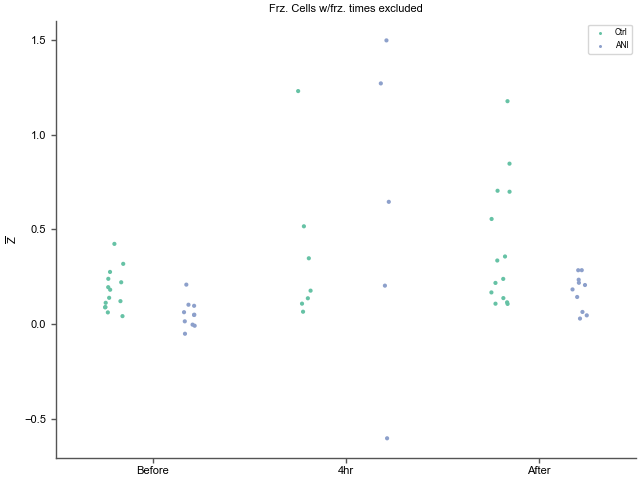

In [25]:
# Plot above
_, ax_wo_ftimes = plt.subplots(figsize=(3, 3))

df_use, a = sigz_wo_frz_times_df, ax_wo_ftimes
gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
gfg.legend(fontsize=6, markerscale=0.15)
a.set_title('Frz. Cells w/frz. times excluded', fontsize=8)
a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
a.set_xlabel('', fontsize=8)
a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
plt.setp(a.spines.values(), linewidth=1)
sns.despine(ax=a)


### Same set of plots but now tracking freeze-cells identified on a particular day backward/forward in time

In [26]:
# Create dataframe to track cell covariance across days
sig4frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
sig1frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
sig2frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[2, 2, 2, 2, 2],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)

# Clean up and reshape dataframe
sig4frz_dfreg = cova.cov_dict_to_df(sig4frz_cov_dict, all_cov, register=True)
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])

sig1frz_dfreg = cova.cov_dict_to_df(sig1frz_cov_dict, all_cov, register=True)
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

sig2frz_dfreg = cova.cov_dict_to_df(sig2frz_cov_dict, all_cov, register=True)
sig2frz_dfreg = add_memory_designations(sig2frz_dfreg, before=['2_-2', '2_-1'], during=['2_4'], after=['2_1', '2_2'])

Marble07: 5it [00:04,  1.02it/s]
Marble12: 5it [00:04,  1.20it/s]
Marble24: 5it [00:04,  1.22it/s]
Marble27: 5it [00:04,  1.14it/s]
Marble06: 5it [00:04,  1.11it/s]
Marble11: 5it [00:05,  1.19s/it]
Marble29: 5it [00:04,  1.11it/s]
Marble17: 5it [00:05,  1.04s/it]
Marble18: 5it [00:04,  1.23it/s]
Marble19: 5it [00:04,  1.13it/s]
Marble20: 5it [00:04,  1.24it/s]
Marble25: 5it [00:04,  1.11it/s]
Marble07: 5it [00:04,  1.02it/s]
Marble12: 5it [00:04,  1.19it/s]
Marble24: 5it [00:04,  1.16it/s]
Marble27: 5it [00:04,  1.13it/s]
Marble06: 5it [00:04,  1.13it/s]
Marble11: 5it [00:05,  1.18s/it]
Marble29: 5it [00:04,  1.09it/s]
Marble17: 5it [00:05,  1.04s/it]
Marble18: 5it [00:04,  1.23it/s]
Marble19: 5it [00:04,  1.08it/s]
Marble20: 5it [00:04,  1.19it/s]
Marble25: 5it [00:04,  1.08it/s]
Marble07: 5it [00:04,  1.02it/s]
Marble12: 5it [00:04,  1.18it/s]
Marble24: 5it [00:04,  1.12it/s]
Marble27: 5it [00:04,  1.16it/s]
Marble06: 5it [00:04,  1.10it/s]
Marble11: 5it [00:05,  1.19s/it]
Marble29: 

In [27]:
# Day 4 freeze cells
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
sig4frz_dfreg = add_in_subject_id(sig4frz_dfreg)
stats4reg = pg.anova(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw4reg = pg.pairwise_tests(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
# print(stats4reg)
# print(pw4reg)

In [28]:
# Day 1 freeze cells
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])
sig1frz_dfreg = add_in_subject_id(sig1frz_dfreg)
stats1reg = pg.anova(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw1reg = pg.pairwise_tests(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
# print(stats1reg)
# print(pw1reg)

In [29]:
# Now plot 4 hr and Day 1 freeze cells backward/forward in time
areg4, areg4stats = Fig3comb.subplot(Fig3.gs[3, 2])
areg1, areg1stats = Fig3comb.subplot(Fig3.gs[3, 3])

for df_use, ap, astat, title_use in zip([sig4frz_dfreg, sig1frz_dfreg], [areg4, areg1], 
                                        [areg4stats, areg1stats], ['4 hr. frz cells - tracked across sessions', 
                                                                   '1 day frz cells - Tracked across sessions']):
    # Plot data
    sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use, dodge=True, ax=ap, size=3,
                  palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', between=['Group', 'Designation'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


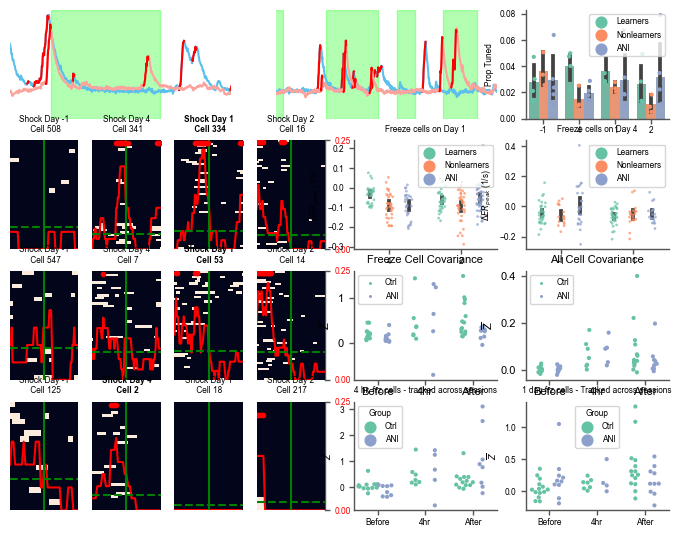

In [30]:
Fig3.fig

### Last, identical plots but for groups of cells that significantly covary on a given day.  
i.e. are any effects we see specific to freeze-tuned cells or do they generalize to other types of cells that might form an ensemble on a given day

In [31]:
# Consider significantly covarying cells from 4 hr and 1 day session
sig4_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)
sig4_dfreg = cova.cov_dict_to_df(sig4_cov_dict, all_cov, register=True)
sig1_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)
sig1_dfreg = cova.cov_dict_to_df(sig1_cov_dict, all_cov, register=True)
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

Marble07: 5it [00:03,  1.39it/s]
Marble12: 5it [00:03,  1.63it/s]
Marble24: 5it [00:03,  1.65it/s]
Marble27: 5it [00:03,  1.55it/s]
Marble06: 5it [00:03,  1.51it/s]
Marble11: 5it [00:04,  1.10it/s]
Marble29: 5it [00:03,  1.50it/s]
Marble17: 5it [00:03,  1.29it/s]
Marble18: 5it [00:02,  1.68it/s]
Marble19: 5it [00:03,  1.48it/s]
Marble20: 5it [00:02,  1.68it/s]
Marble25: 5it [00:03,  1.50it/s]
Marble07: 5it [00:03,  1.39it/s]
Marble12: 5it [00:03,  1.62it/s]
Marble24: 5it [00:03,  1.59it/s]
Marble27: 5it [00:03,  1.57it/s]
Marble06: 5it [00:03,  1.53it/s]
Marble11: 5it [00:04,  1.09it/s]
Marble29: 5it [00:03,  1.49it/s]
Marble17: 5it [00:03,  1.28it/s]
Marble18: 5it [00:02,  1.67it/s]
Marble19: 5it [00:03,  1.46it/s]
Marble20: 5it [00:03,  1.65it/s]
Marble25: 5it [00:03,  1.46it/s]


In [32]:
# Now plot this with sats
sig4_dfreg = add_memory_designations(sig4_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
sig4_dfreg = add_in_subject_id(sig4_dfreg)
sig1_dfreg = add_memory_designations(sig1_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_2'])
sig1_dfreg = add_in_subject_id(sig1_dfreg)

# fig4, ax4 = plt.subplots(1, 2)
# fig1, ax1 = plt.subplots(1, 2)
ax4reg, ax4reg_stats = FigS6comb.subplot(FigS6.gs[3, 2])
ax1reg, ax1reg_stats = FigS6comb.subplot(FigS6.gs[3, 3])

for df_use, ap, astat, title_use in zip([sig4_dfreg, sig1_dfreg], [ax4reg, ax1reg], [ax4reg_stats, ax1reg_stats], 
                                        ['4 hr. sig cells - tracked across sessions', 
                                         '1 day sig cells - Tracked across sessions']):
    # Plot data
    sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use[df_use['Designation'] != ""], 
                  dodge=True, ax=ap, size=3, palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', between=['Group', 'Designation'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
#                                dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


### NRK todos!
0) ~~Dump in cell #53 for Evan in lieu of #36 to match example traces.~~

1) ~~Fix all above to NOT use mixed anova AND fix anything in Figure 2 that might use the same methodology.  Seems to be improperly accounting for multiple "Before" and "After" entries for the same mouse - is it just ignoring one or eliminating one? Tough to tell.  Figure this out~~  mixed_anova gives super low DOFs - not correctly grabbing data points!

2) Look at covariance of all sig place fields on day -1, 4 hr, and day 1 and track covariance across days.

3) ~~Make sure any increases we see in ANI mice aren't due to learning on day -1. Assess this by tracking OPEN field cells from day -2 to day 0 in the same manner as you look at other cells (e.g. All cells covariance plot). If we see an increase from days -2/-1 to day 0 that would mean something is being consolidated after day -1 and could explain why we see some increases in ANI mice covariance in the days following ANI administration.~~

### Last, track Open cell covariance across days - do we see an increase in firing just due to habituation prior to any shock?  Answer is no.

In [33]:
all_cov_open = cova.group_cov_across_days(bin_size=bin_size, arena1='Open', arena2='Open', neurons='all', 
                                          keep_silent=True, base_days=[-2, -1, 4, 1, 2, -1, 0], 
                                          reg_days=[-1, 4, 1, 2, 7, 0, 4])
sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True)
sigz_all_open_df = add_memory_designations(sigz_all_open_df)

Marble07: 0it [00:00, ?it/s]

No tunings found for Marble07 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 5it [00:16,  3.34s/it]

No tunings found for Marble07 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:20,  3.36s/it]

No tunings found for Marble07 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble07 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 7it [00:23,  3.35s/it]
Marble12: 0it [00:00, ?it/s]

No tunings found for Marble12 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 5it [00:16,  3.26s/it]

No tunings found for Marble12 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:19,  3.22s/it]

No tunings found for Marble12 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble12 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 7it [00:22,  3.23s/it]
Marble24: 0it [00:00, ?it/s]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
No tunings found for Marble24 Open day -2: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4


Marble24: 1it [00:03,  3.31s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4


Marble24: 5it [00:16,  3.28s/it]

No tunings found for Marble24 Open day 7: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181128_1_openfield: nbadpts = 50 max_in_a_row = 12
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181128_1_openfield: nbadpts = 50 max_in_a_row = 12


Marble24: 6it [00:19,  3.29s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181128_1_openfield: nbadpts = 50 max_in_a_row = 12
No tunings found for Marble24 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181128_1_openfield: nbadpts = 50 max_in_a_row = 12
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181128_1_openfield: nbadpts = 50 max_in_a_row = 12
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181128_1_openfield: nbadpts = 50 max_in_a_row = 12
No tunings found for Marble24 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 7it [00:22,  3.26s/it]
Marble27: 0it [00:00, ?it/s]

No tunings found for Marble27 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 5it [00:16,  3.30s/it]

No tunings found for Marble27 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:19,  3.31s/it]

No tunings found for Marble27 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble27 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 7it [00:23,  3.29s/it]
Marble06: 0it [00:00, ?it/s]

No tunings found for Marble06 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble06: 3it [00:10,  3.34s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38


Marble06: 4it [00:13,  3.40s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
No position data found for Marble06 Open day 7, loading neural data only


Marble06: 5it [00:17,  3.63s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180419_1_openfield: nbadpts = 13 max_in_a_row = 5
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180419_1_openfield: nbadpts = 13 max_in_a_row = 5


Marble06: 6it [00:20,  3.50s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180419_1_openfield: nbadpts = 13 max_in_a_row = 5
No tunings found for Marble06 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180419_1_openfield: nbadpts = 13 max_in_a_row = 5
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180419_1_openfield: nbadpts = 13 max_in_a_row = 5
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180419_1_openfield: nbadpts = 13 max_in_a_row = 5
No tunings found for Marble06 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble06: 7it [00:24,  3.45s/it]
Marble11: 0it [00:00, ?it/s]

No tunings found for Marble11 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 5it [00:17,  3.53s/it]

No tunings found for Marble11 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:21,  3.56s/it]

No tunings found for Marble11 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble11 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 7it [00:24,  3.57s/it]
Marble29: 0it [00:00, ?it/s]

No tunings found for Marble29 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 5it [00:16,  3.37s/it]

No tunings found for Marble29 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:20,  3.40s/it]

No tunings found for Marble29 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble29 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 7it [00:23,  3.39s/it]
Marble17: 0it [00:00, ?it/s]

No tunings found for Marble17 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 5it [00:17,  3.46s/it]

No tunings found for Marble17 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:20,  3.46s/it]

No tunings found for Marble17 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble17 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 7it [00:24,  3.46s/it]
Marble18: 0it [00:00, ?it/s]

No tunings found for Marble18 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 5it [00:15,  3.18s/it]

No tunings found for Marble18 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:19,  3.20s/it]

No tunings found for Marble18 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble18 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 7it [00:22,  3.18s/it]
Marble19: 0it [00:00, ?it/s]

No tunings found for Marble19 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 5it [00:16,  3.34s/it]

No tunings found for Marble19 Open day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:20,  3.34s/it]

No tunings found for Marble19 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
No tunings found for Marble19 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 7it [00:23,  3.34s/it]
Marble20: 0it [00:00, ?it/s]

No tunings found for Marble20 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 5it [00:16,  3.22s/it]

No tunings found for Marble20 Open day 7: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble20_10Hz/20181010_1_openfield: nbadpts = 24 max_in_a_row = 18
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble20_10Hz/20181010_1_openfield: nbadpts = 24 max_in_a_row = 18


Marble20: 6it [00:19,  3.26s/it]

/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble20_10Hz/20181010_1_openfield: nbadpts = 24 max_in_a_row = 18
No tunings found for Marble20 Open day 0: run .get_tuning_sig() and .save_sig_tuning()
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble20_10Hz/20181010_1_openfield: nbadpts = 24 max_in_a_row = 18
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble20_10Hz/20181010_1_openfield: nbadpts = 24 max_in_a_row = 18
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble20_10Hz/20181010_1_openfield: nbadpts = 24 max_in_a_row = 18
No tunings found for Marble20 Open day 0: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 7it [00:22,  3.25s/it]
Marble25: 0it [00:00, ?it/s]

/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
No tunings found for Marble25 Open day -2: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 5it [00:16,  3.32s/it]

No tunings found for Marble25 Open day 7: run .get_tuning_sig() and .save_sig_tuning()
No position data found for Marble25 Open day 0, loading neural data only


Marble25: 6it [00:22,  4.16s/it]

No position data found for Marble25 Open day 0, loading neural data only
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow


Marble25: 7it [00:32,  4.59s/it]


In [34]:
sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True)
sigz_all_open_df = add_memory_designations(sigz_all_open_df, before=['-2_-1'], during=['-1_0'], after=['0_4'] )
sigz_all_open_df['Designation'].iloc[sigz_all_open_df['Designation'] == '4hr'] = 'Day -1'

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [35]:
ax_open_covar, ax_open_covar_stats = FigS6comb.subplot(FigS6.gs[2, 3])
ap, astat = ax_open_covar, ax_open_covar_stats
# _, atemp = plt.subplots(1, 2, figsize=(6, 3))
# ap, astat = atemp[0], atemp[1]
title_use = 'Neutral Arena Covariance'
df_use = sigz_all_open_df
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use[df_use['Designation'] != ""], 
                  dodge=True, ax=ap, size=3, palette=cmap_use)

ap.set_title(title_use)
ap.set_xlabel('')
ap.set_ylabel(r'$\overline{Z}$')

# Calc and plot stats
stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                      df_use['Designation'] != "")], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                      df_use['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
#                                dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
astat.set_title(title_use)
astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})

Text(0.1, 0.05, '              Contrast Group       A       B Paired  Parametric  U-val  \\\n0                Group     -     ANI    Ctrl  False       False  170.0   \n1          Designation     -   After  Before  False       False  111.0   \n2          Designation     -   After  Day -1  False       False   59.0   \n3          Designation     -  Before  Day -1  False       False   13.0   \n4  Group * Designation   ANI   After  Before  False       False   20.0   \n5  Group * Designation   ANI   After  Day -1  False       False   13.0   \n6  Group * Designation   ANI  Before  Day -1  False       False    3.0   \n7  Group * Designation  Ctrl   After  Before  False       False   37.0   \n8  Group * Designation  Ctrl   After  Day -1  False       False   16.0   \n9  Group * Designation  Ctrl  Before  Day -1  False       False    4.0   \n\n  alternative     p-unc    p-corr p-adjust    hedges  \n0   two-sided  0.700201       NaN      NaN  0.264663  \n1   two-sided  0.026229  0.078688     bonf 

In [36]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
Fig3.savefig(plot_path / 'Figure3.pdf', scriptname='Figure3.ipynb')
Fig3stats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3.ipynb')

/Users/nkinsky/Documents/BU/GitHub/Eraser/plotting.py:259: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(filename, dpi=dpi, backend="pdf")


In [37]:
FigS6.savefig(plot_path / 'FigureS6.pdf', scriptname='Figure3.ipynb')
FigS6stats.savefig(plot_path / 'FigureS6stats.pdf', scriptname='Figure3.ipynb')